# Predicción



### Sentinel 2 rgb nir swir diffsw

In [ ]:
!pip install -e /home/ro/unetseg/

In [1]:
from unetseg.predict import PredictConfig, predict
from unetseg.evaluate import plot_data_results
import os

/opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/miniconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/

In [ ]:
!rm -rf /home/ro/basurales/data/data_results/

In [2]:

predict_config = PredictConfig(
                                    images_path=os.path.join('/home/ro/basurales/data/data_predict/','6D','100_100'), # ruta a las imagenes sobre las cuales queremos predecir
                                    results_path=os.path.join('/home/ro/basurales/data/data_results/','6D' ,'100_100'), # ruta de destino para nuestra predicción
                                    batch_size=16,
                                    model_path=os.path.join('/home/ro/basurales/data/weights/', 'UNet_basurales_6D_100_30_spe200_.h5'),  #  ruta al modelo (.h5)
                                    height=160,
                                    width=160,
                                    n_channels=6,
                                    n_classes=1)
          
   

In [ ]:
predict(predict_config)  # Ejecuta la predicción

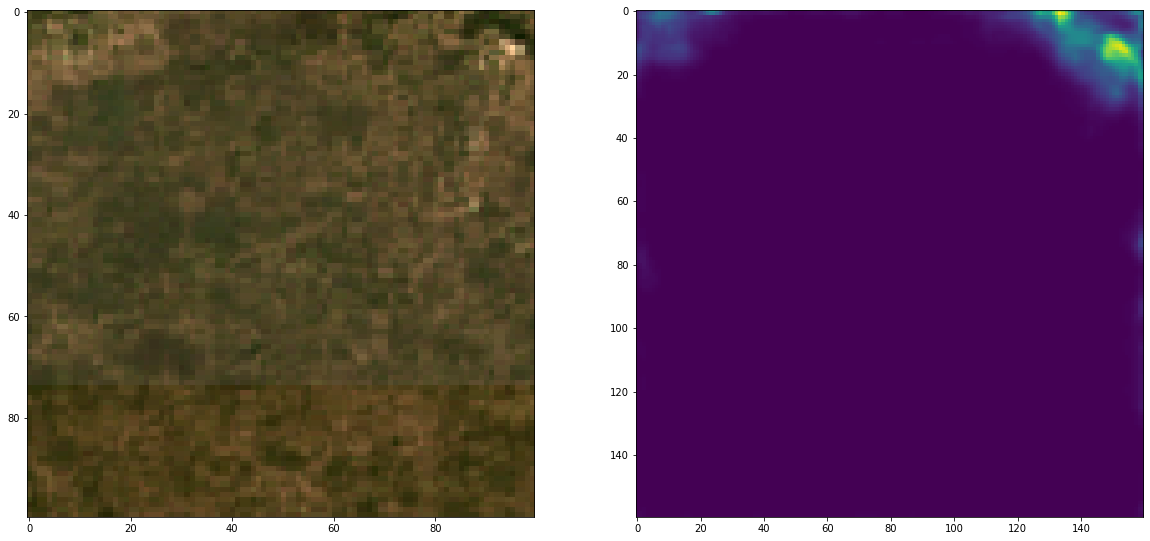

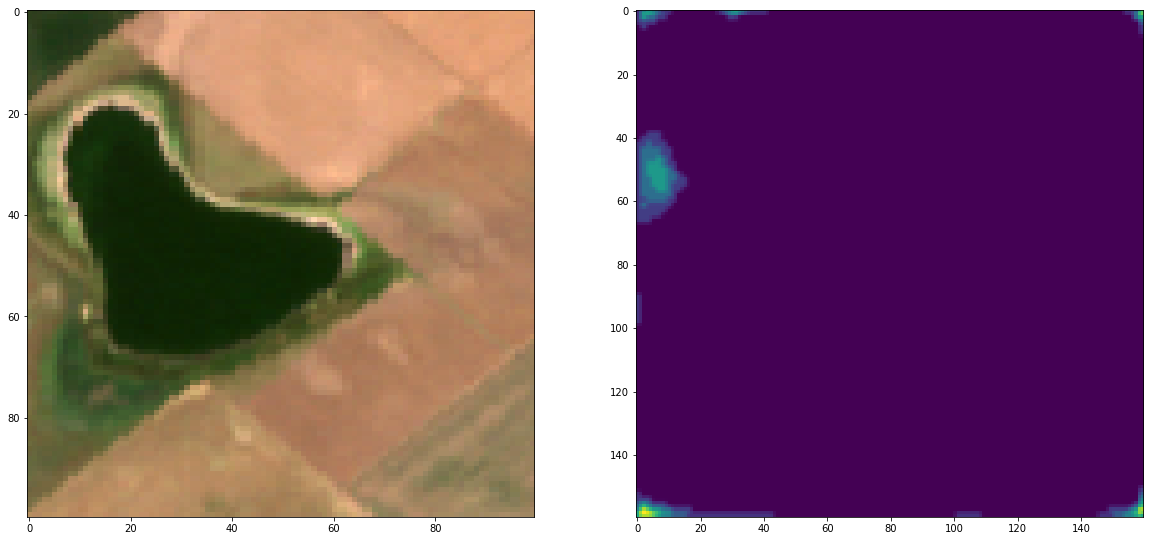

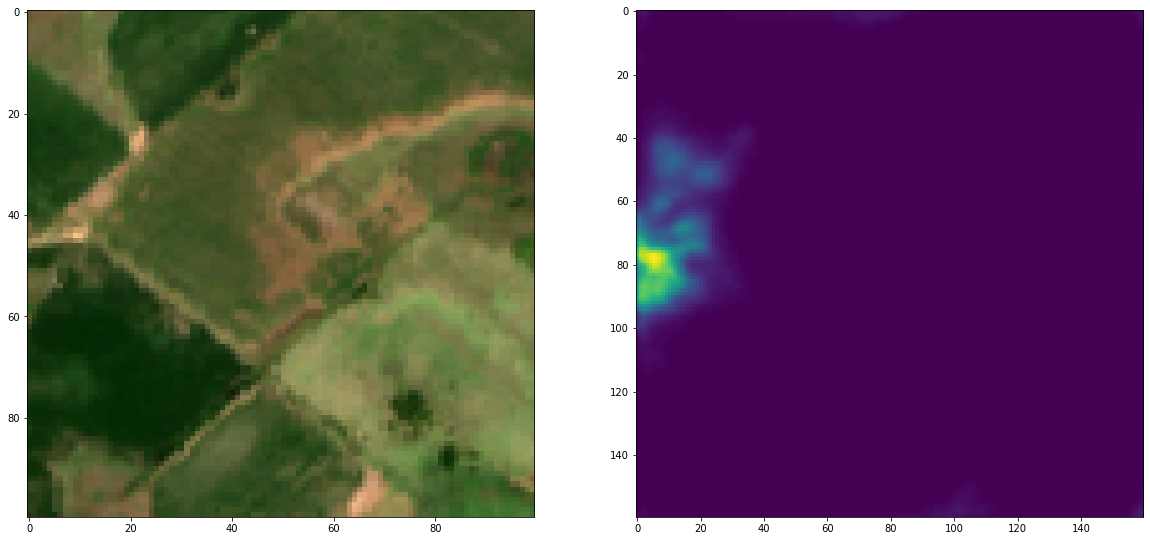

In [3]:

plot_data_results(num_samples=3, fig_size=(10, 10), predict_config=predict_config, img_ch =3)
